# Analisis exploratorio inicial de datos de CAF

### 4. Exploracion inicial
- Analisis de la correlación simple
- Analisis de la correlación cruzada
- Analisis de autocorrelación
- Propuesta de variables a descartar

In [1]:
# !pip install colorlog
# !pip install git+https://github.com/tkrajina/srtm.py.git
# !pip install s3fs
!pip install git+https://github.com/maguelo/cafcoding.git#egg=cafcoding

In [2]:
import pandas as pd
import numpy as np
import pickle
import io
import os
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# import sys
# sys.path.insert(0,"..")
# !pip install seaborn
from cafcoding.tools import visualization
from cafcoding.tools import analysis
import cafcoding.tools.dataset as dataset
import cafcoding.tools.aws as aws

import cafcoding.stages.etl_step as etl_step
import cafcoding.tools.log as log

logger = log.get_logger()

# from cafcoding.tools import meteo
# from cafcoding.stages import etl_step

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
SHOW_PLOT = True

# Cargamos la sesion de Amazon

In [6]:
import cafcoding.tools.aws as aws
amazon = aws.AWS("/content/drive/MyDrive/CAFcoding/config/awscli.ini")

# Activamos las credenciales
amazon.set_credentials_in_env()

/content/drive/MyDrive/CAFcoding/config/awscli.ini


# Cargamos el dataset



In [7]:
df = dataset.DatasetLoader().load_df_train(1)

 [Wed, 21 Apr 2021 20:31:50] INFO [dataset.py.__init__:28] Using datasource from s3 s3://cafcodingdatos/targets_mirror/{step}/2020-{month:02d}-{day:02d}-etl-{version}.csv
s3://cafcodingdatos/targets_mirror/train/2020-10-01-etl-1.2.1.csv


In [8]:
#df = df.head(7000)

In [9]:
conf_dict={'targets':['TCU1_LinePowerConsumed','TCU1_LinePowerDissipated',	'TCU1_LinePowerReturned',
                    'TCU2_LinePowerConsumed','TCU2_LinePowerDissipated',	'TCU2_LinePowerReturned',
                    'TCU3_LinePowerConsumed','TCU3_LinePowerDissipated',	'TCU3_LinePowerReturned',
                    'TCU4_LinePowerConsumed','TCU4_LinePowerDissipated',	'TCU4_LinePowerReturned'], 
           'ignore_columns':['ut','ts_date','date_day']}
            

In [10]:
variables_objetivo=conf_dict['targets']
# si quereis incluir variables objetivo en el modelo descomentar esta linea
#variables_objetivo=[]                  


In [11]:
df.head()


ut  ...  plc_mcp_error_unknown_requested
ts_date_index             ...                                 
2020-10-01 03:49:14  906  ...                                0
2020-10-01 03:49:15  906  ...                                0
2020-10-01 03:49:16  906  ...                                0
2020-10-01 03:49:17  906  ...                                0
2020-10-01 03:49:18  906  ...                                0

[5 rows x 142 columns]

In [12]:
df.ut.value_counts()

926    51108
920    50313
924    49867
906    47964
914    47469
908    46240
925    39577
912     7202
918     6154
916      349
Name: ut, dtype: int64

In [13]:
df.isna().sum()

ut                                     0
TCU1_LinePowerConsumed                 0
TCU1_LinePowerDissipated               0
TCU1_LinePowerReturned                 0
TCU2_LinePowerConsumed                 0
                                      ..
plc_mcp_urgency_brake_requested        0
plc_mcp_braking_effort_requested       0
plc_mcp_coasting_requested             0
plc_mcp_propulsion_effort_requested    0
plc_mcp_error_unknown_requested        0
Length: 142, dtype: int64

In [14]:
list_ut = df.ut.unique()#df=df[df.ut==912]
print (list_ut)
conf_dict['list_ut']=list_ut

[906 908 912 914 916 918 920 924 925 926]


# Analisis de correlacion

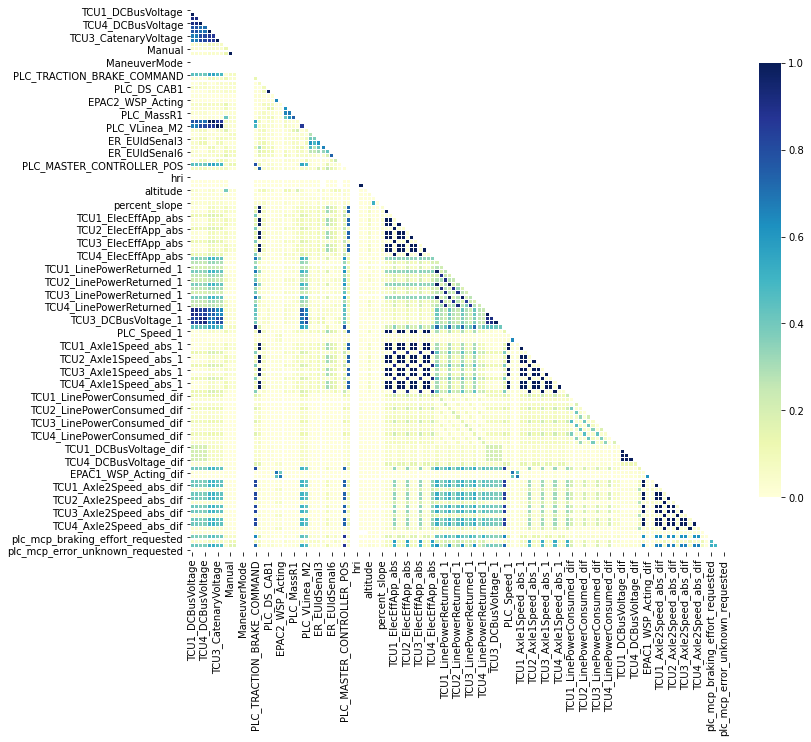

In [15]:
corr = analysis.correlation(df, conf_dict['ignore_columns']+variables_objetivo)
if SHOW_PLOT:
    visualization.plot_correlation(corr)

In [16]:
columns = list(df.columns)
df_new = analysis.df_derived_by_shift(df, 3, conf_dict['ignore_columns']+variables_objetivo)

In [17]:
df_new = df_new.dropna()
print (len(df_new.columns))

523


In [18]:
df_new

ut  ...  plc_mcp_error_unknown_requested_3
149227  918  ...                                0.0
149228  918  ...                                0.0
149229  918  ...                                0.0
149230  918  ...                                0.0
149231  918  ...                                0.0
...     ...  ...                                ...
155373  918  ...                                0.0
155374  918  ...                                0.0
155375  918  ...                                0.0
155376  918  ...                                0.0
155377  918  ...                                0.0

[6151 rows x 523 columns]

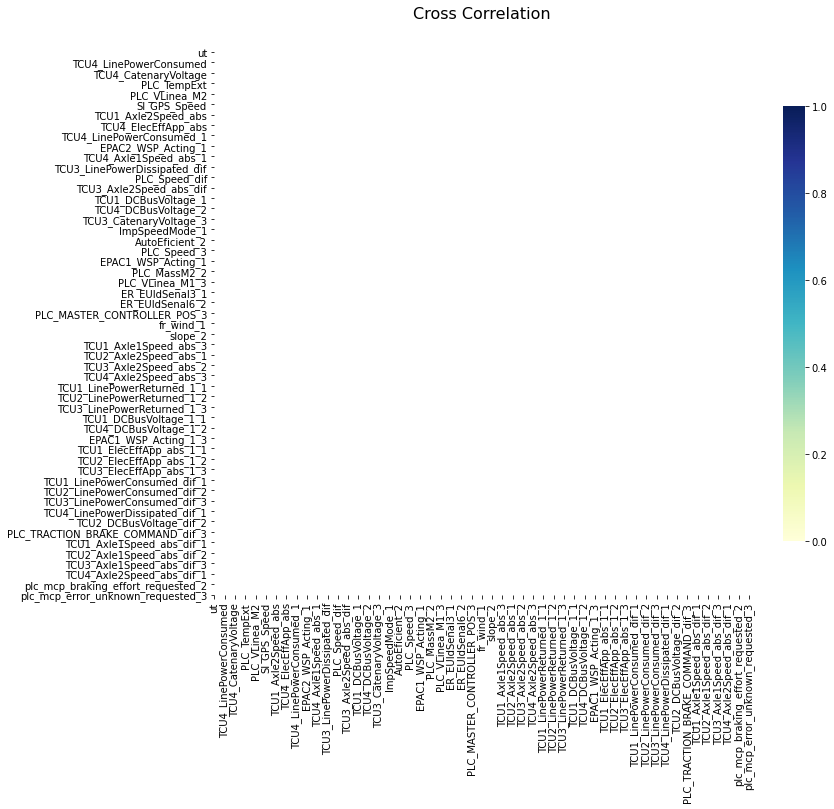

In [19]:
corr = analysis.correlation(df_new)
if SHOW_PLOT:
    visualization.plot_correlation(corr, title="Cross Correlation")

# Analisis de autocorrelación

TCUx_LinePowerConsumed, TCUx_LinePowerDissipated, TCUx_LinePowerReturned


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


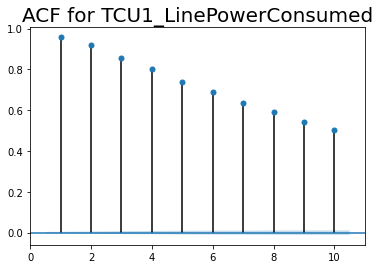

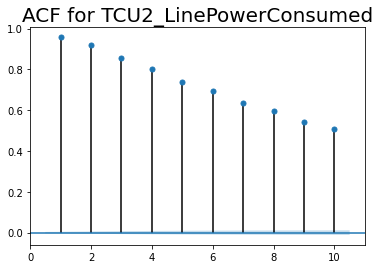

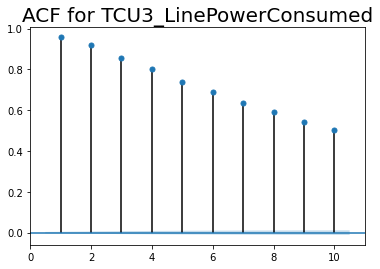

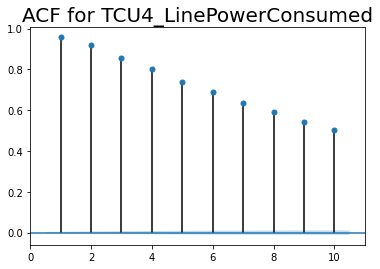

In [20]:
import statsmodels.graphics.tsaplots as sgt

TIME_LAG = 10

sgt.plot_acf(df['TCU1_LinePowerConsumed'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU1_LinePowerConsumed", size = 20)
plt.show()

sgt.plot_acf(df['TCU2_LinePowerConsumed'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU2_LinePowerConsumed", size = 20)
plt.show()

sgt.plot_acf(df['TCU3_LinePowerConsumed'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU3_LinePowerConsumed", size = 20)
plt.show()


sgt.plot_acf(df['TCU4_LinePowerConsumed'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU4_LinePowerConsumed", size = 20)
plt.show()

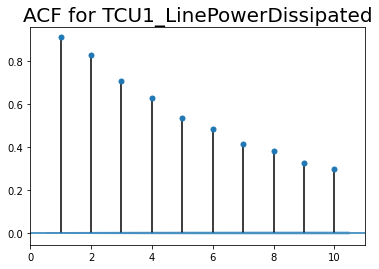

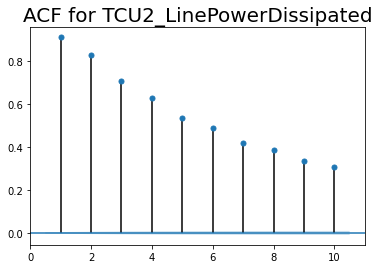

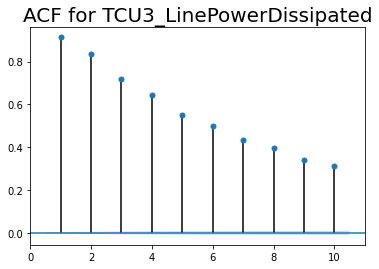

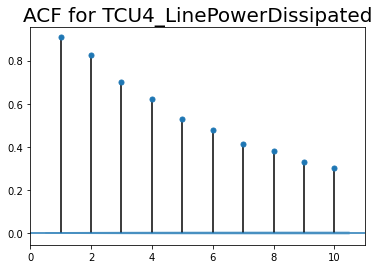

In [21]:
sgt.plot_acf(df['TCU1_LinePowerDissipated'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU1_LinePowerDissipated", size = 20)
plt.show()

sgt.plot_acf(df['TCU2_LinePowerDissipated'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU2_LinePowerDissipated", size = 20)
plt.show()

sgt.plot_acf(df['TCU3_LinePowerDissipated'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU3_LinePowerDissipated", size = 20)
plt.show()

sgt.plot_acf(df['TCU4_LinePowerDissipated'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU4_LinePowerDissipated", size = 20)
plt.show()

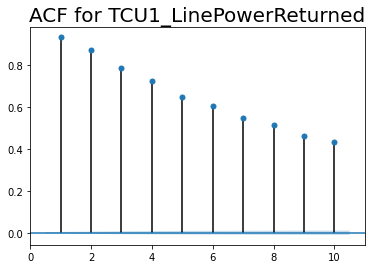

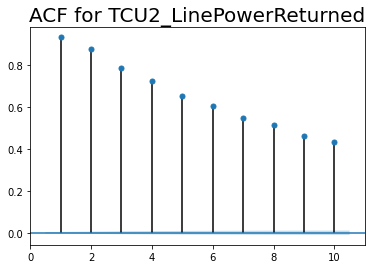

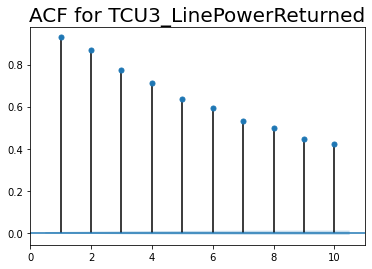

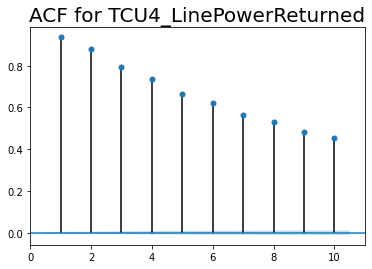

In [22]:
sgt.plot_acf(df['TCU1_LinePowerReturned'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU1_LinePowerReturned", size = 20)
plt.show()

sgt.plot_acf(df['TCU2_LinePowerReturned'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU2_LinePowerReturned", size = 20)
plt.show()

sgt.plot_acf(df['TCU3_LinePowerReturned'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU3_LinePowerReturned", size = 20)
plt.show()

sgt.plot_acf(df['TCU4_LinePowerReturned'], zero = False, lags = TIME_LAG)
plt.title("ACF for TCU4_LinePowerReturned", size = 20)
plt.show()

In [23]:
df.isna().any()
for col in df.columns:
    print (col,df[col].isna().any())

ut False
TCU1_LinePowerConsumed False
TCU1_LinePowerDissipated False
TCU1_LinePowerReturned False
TCU2_LinePowerConsumed False
TCU2_LinePowerDissipated False
TCU2_LinePowerReturned False
TCU3_LinePowerConsumed False
TCU3_LinePowerDissipated False
TCU3_LinePowerReturned False
TCU4_LinePowerConsumed False
TCU4_LinePowerDissipated False
TCU4_LinePowerReturned False
TCU1_DCBusVoltage False
TCU2_DCBusVoltage False
TCU3_DCBusVoltage False
TCU4_DCBusVoltage False
TCU1_CatenaryVoltage False
TCU2_CatenaryVoltage False
TCU3_CatenaryVoltage False
TCU4_CatenaryVoltage False
ER_TotKm False
Manual False
ImpSpeedMode False
ManEficient False
ManeuverMode False
AutoEficient False
Coupled False
PLC_TRACTION_BRAKE_COMMAND False
PLC_Speed False
PLC_TempExt False
PLC_DS_CAB1 False
PLC_DS_CAB2 False
EPAC1_WSP_Acting False
EPAC2_WSP_Acting False
PLC_MassM1 False
PLC_MassM2 False
PLC_MassR1 False
PLC_MassR2 False
PLC_VLinea_M1 False
PLC_VLinea_M2 False
ER_EUIdSenal1 False
ER_EUIdSenal2 False
ER_EUIdSenal3 Fal

# Descartamos variables
### Altamente correlacionadas


In [24]:
THRESHOLD = 0.95
COLUMNS_2_IGNORE = conf_dict['ignore_columns']
def analysis_columns_to_drop(df,variables_objetivo, columns2ignore=COLUMNS_2_IGNORE, visualize=True):
    
    results={}
    print ("Analizamos la correlacion")
    print ("Ignoramos:")
    print ("\n".join(columns2ignore+variables_objetivo))
    corr = analysis.correlation(df,columns2ignore+variables_objetivo)

    corr_drops = analysis.CorrelationStudy(corr).calc_candidates_to_drop(THRESHOLD)
    
    results['corr_drops']=corr_drops
    results['corr']=corr
    
    print ("Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion")
    print ("Ignoramos:")
    print ("\n".join(columns2ignore+variables_objetivo+corr_drops))
    corr = analysis.correlation(df,columns2ignore+corr_drops+variables_objetivo)
    if visualize:
        visualization.plot_correlation(corr, title="Correlation cols dropped")




    print ("Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion")
    print ("Ignoramos:")
    print ("\n".join(columns2ignore+variables_objetivo+corr_drops))
    #     Realizamos la correlacion cruzada eliminando las variables altamente correlacionadas
    columns = list(df.columns)
    shift_columns = [ col+'_1' for col in etl_step.SHIFT_COLUMNS if col+'_1' in columns ]
    df_new = analysis.df_derived_by_shift(df, 3, ignore_columns=columns2ignore+corr_drops+variables_objetivo+shift_columns)

#    print (len(df_new.columns))

    df_new = df_new.dropna()

    
    corr = analysis.correlation(df_new)
    if visualize:
        visualization.plot_correlation(corr, title="Cross correlation cols dropped")

    cross_corr_drops_list = analysis.CorrelationStudy(corr).calc_candidates_to_drop(THRESHOLD)

    results['cross_corr_drops']=cross_corr_drops_list
    results['cross_corr']=corr


    print ("Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada")
    print ("Ignoramos:")
    print ("\n".join(columns2ignore+variables_objetivo+corr_drops))

    corr = analysis.correlation(df_new,cross_corr_drops_list)
    if visualize:
        visualization.plot_correlation(corr, title="Correlation cols dropped")
    return results

TCU1_LinePowerConsumed
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerConsumed
55 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif
TCU2_ElecEffApp_abs_1
T

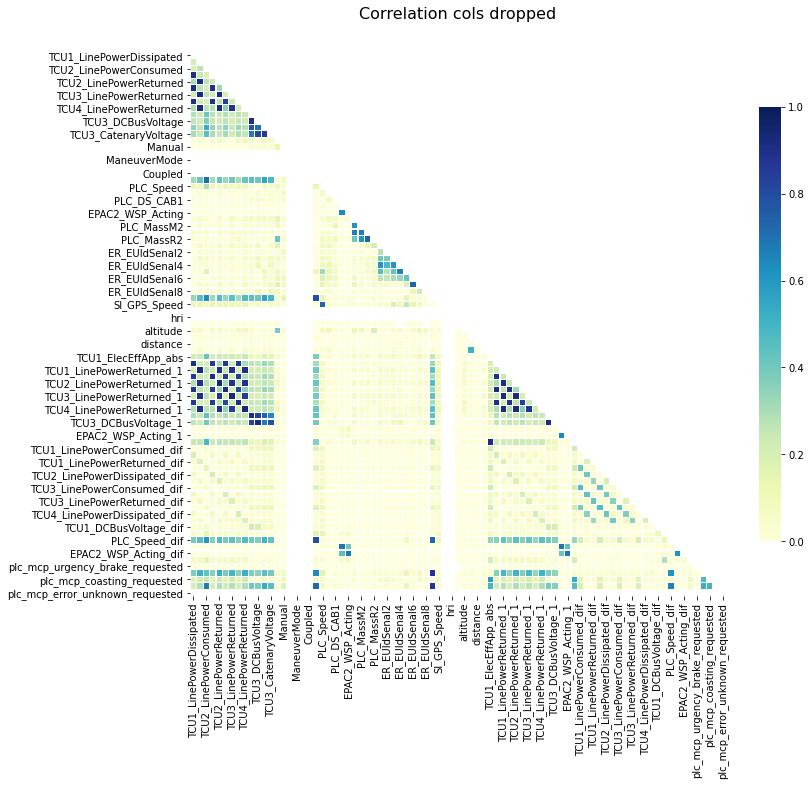

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed_abs_1
TCU3_LinePowerConsumed_

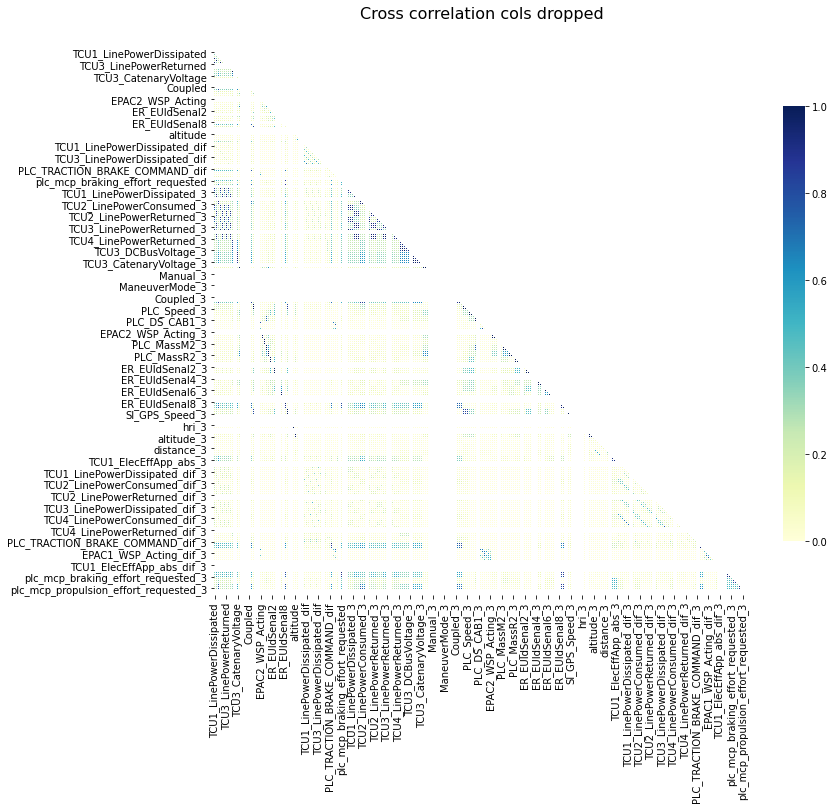

84 / 280
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed_abs_1
TCU3_L

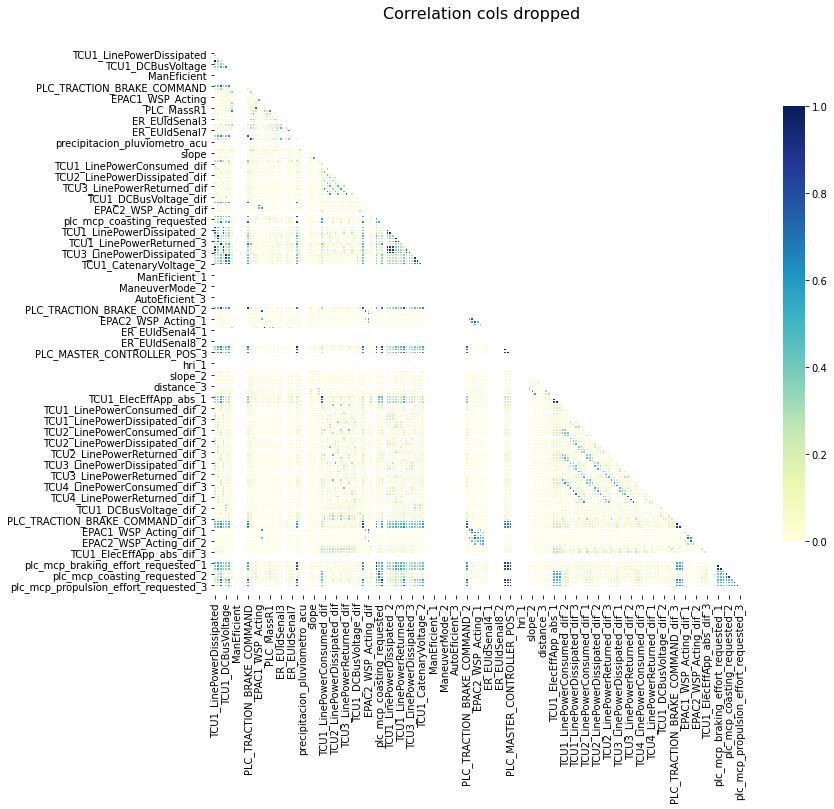

TCU1_LinePowerDissipated
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerDissipated
56 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Ax

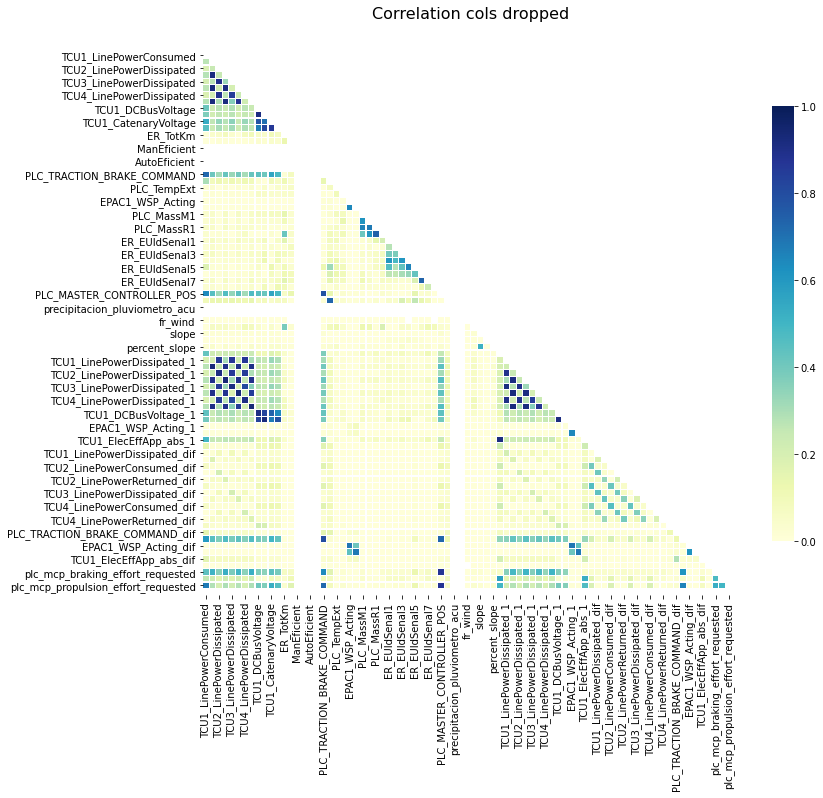

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Spe

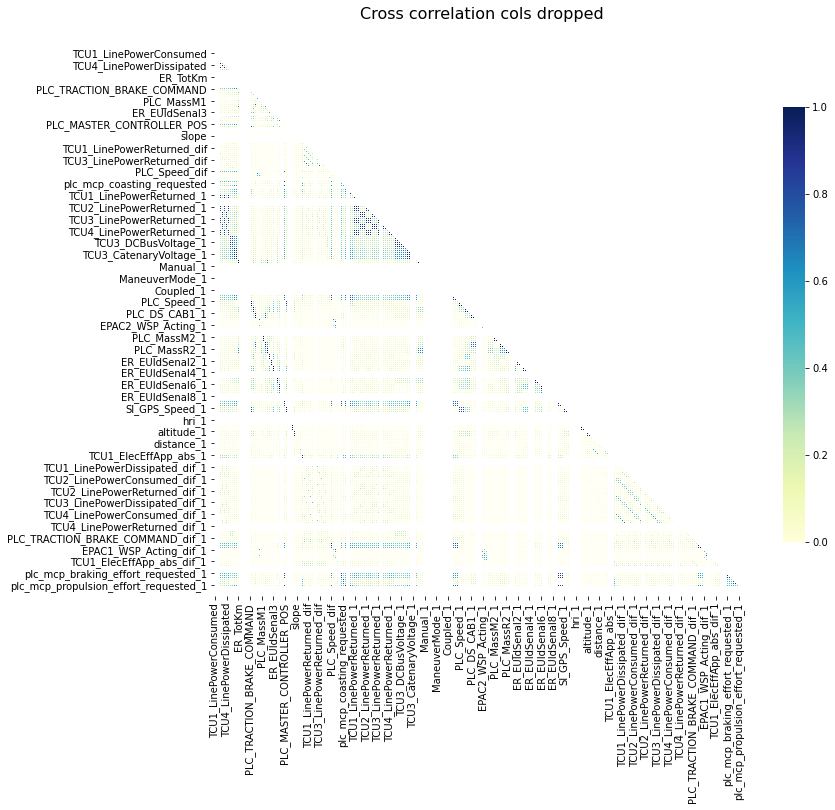

80 / 276
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltag

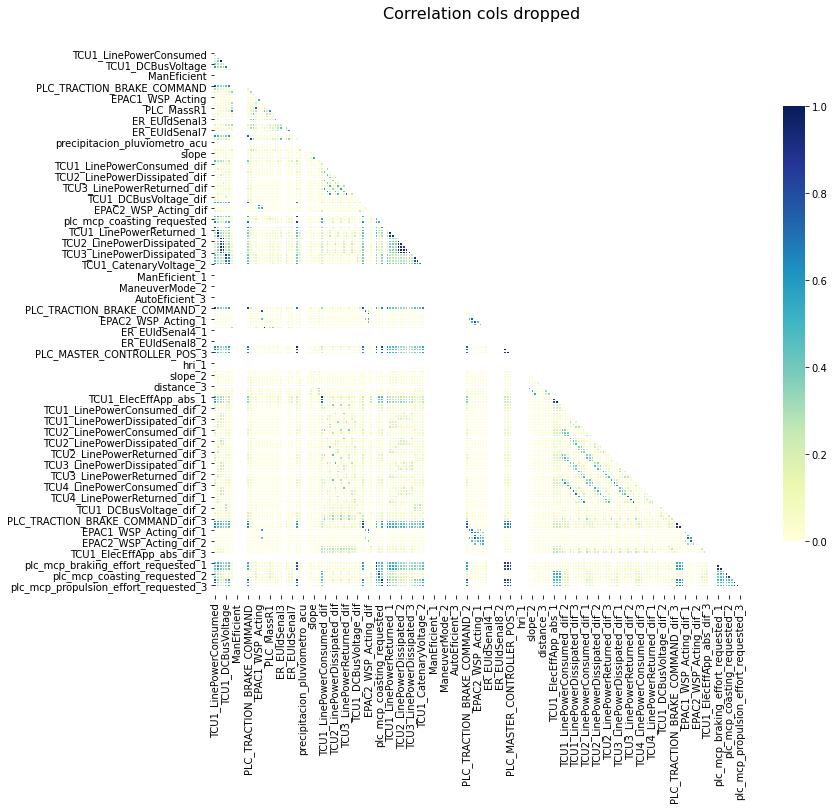

TCU1_LinePowerReturned
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerReturned
56 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Spe

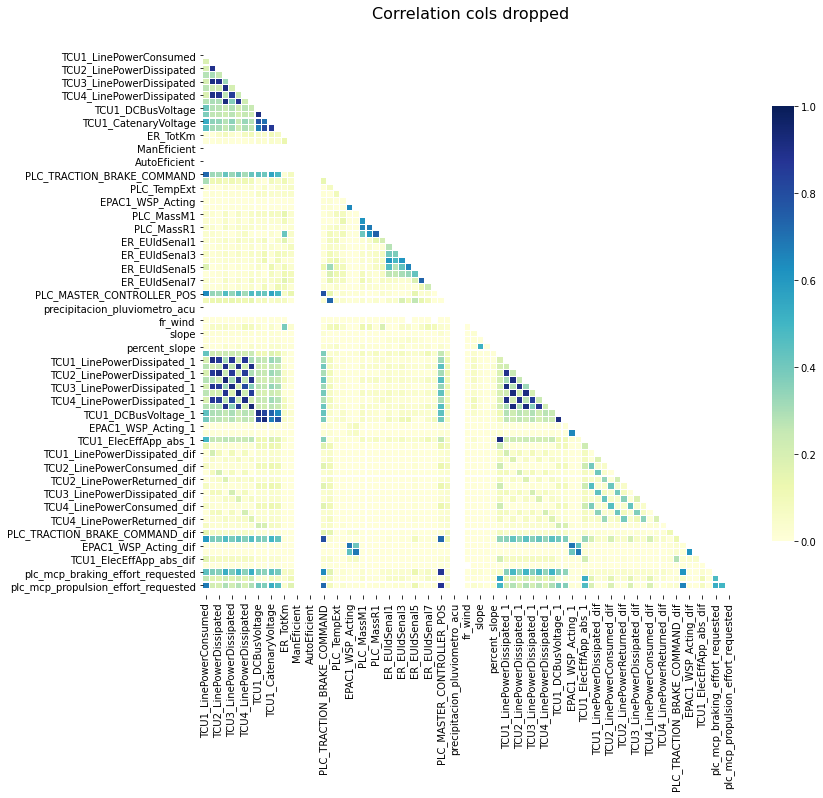

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed

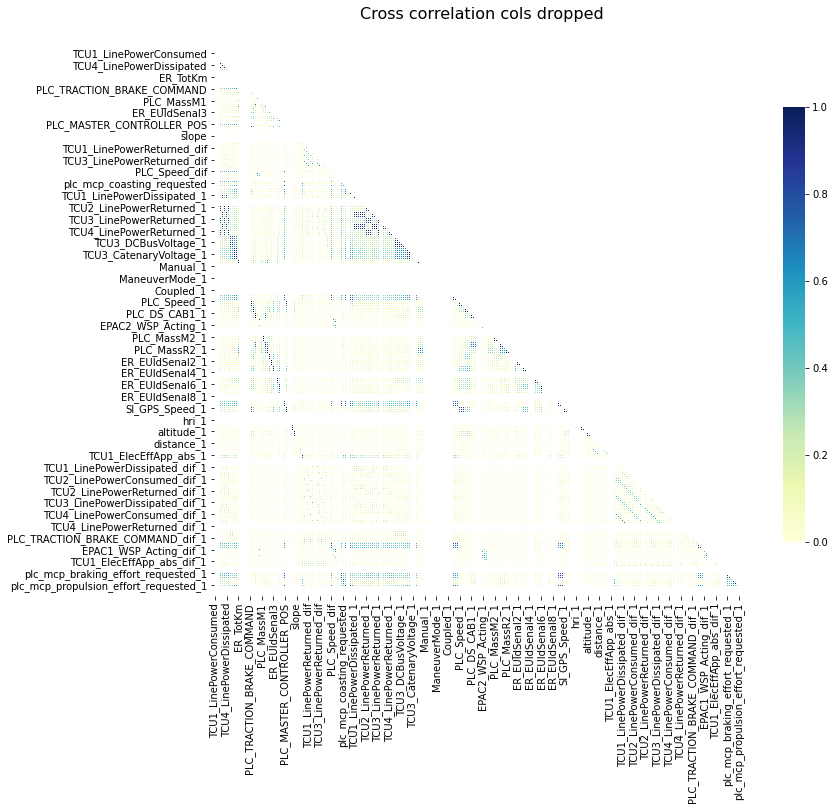

80 / 276
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU1_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_

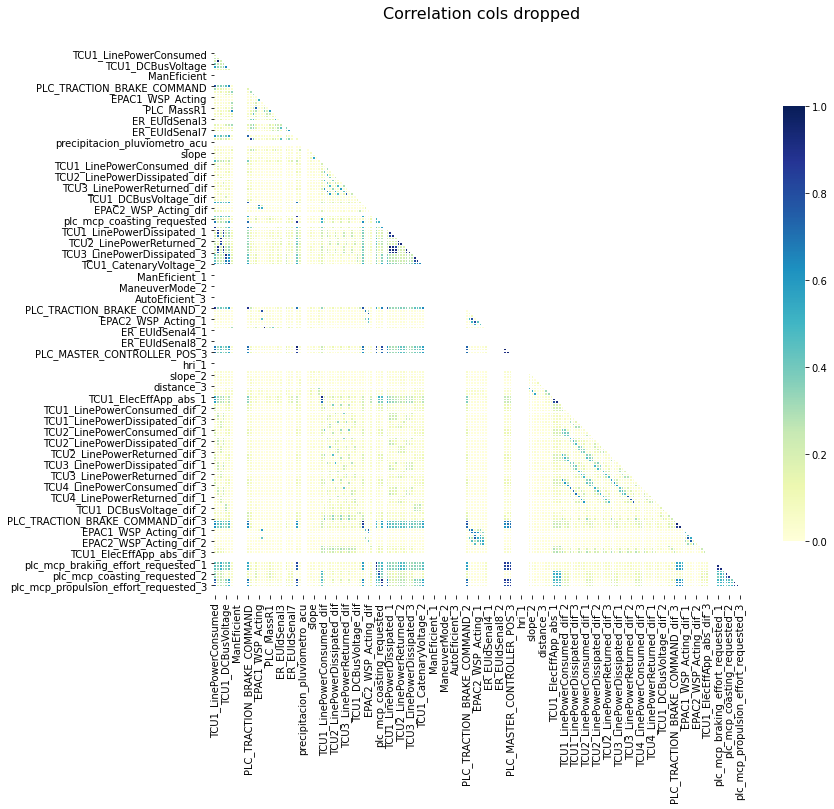

TCU2_LinePowerConsumed
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerConsumed
55 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif
TCU2_ElecEffApp_abs_1
T

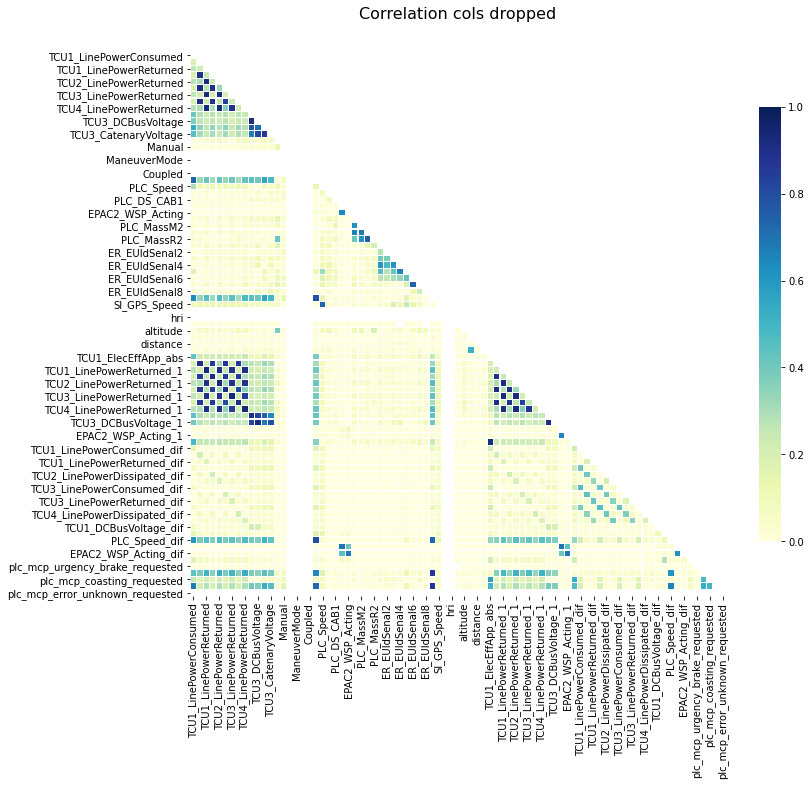

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed_abs_1
TCU3_LinePowerConsumed_

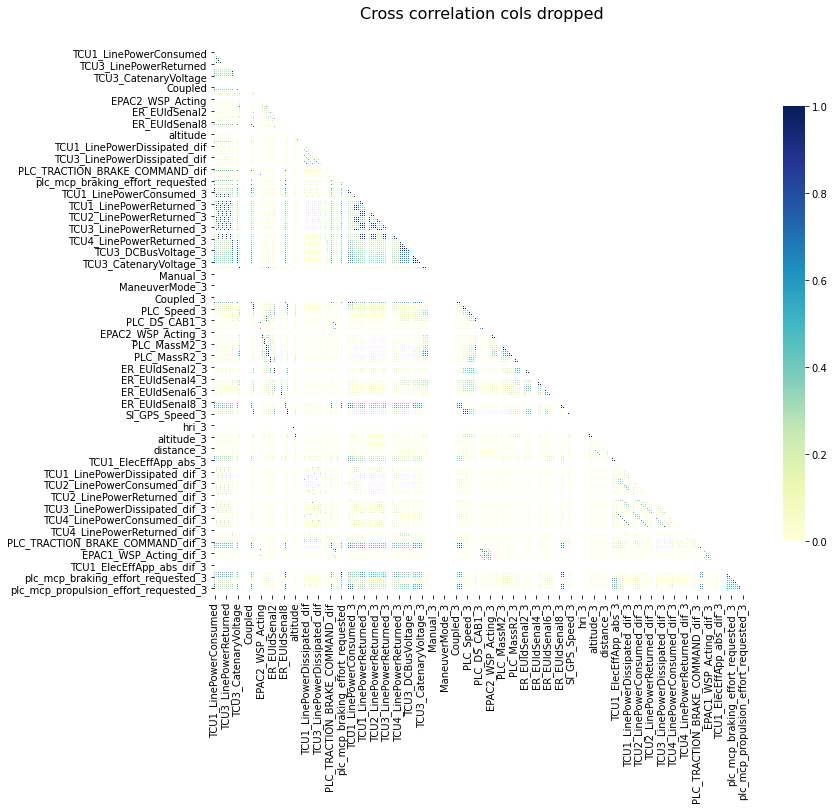

84 / 280
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed_abs_1
TCU3_L

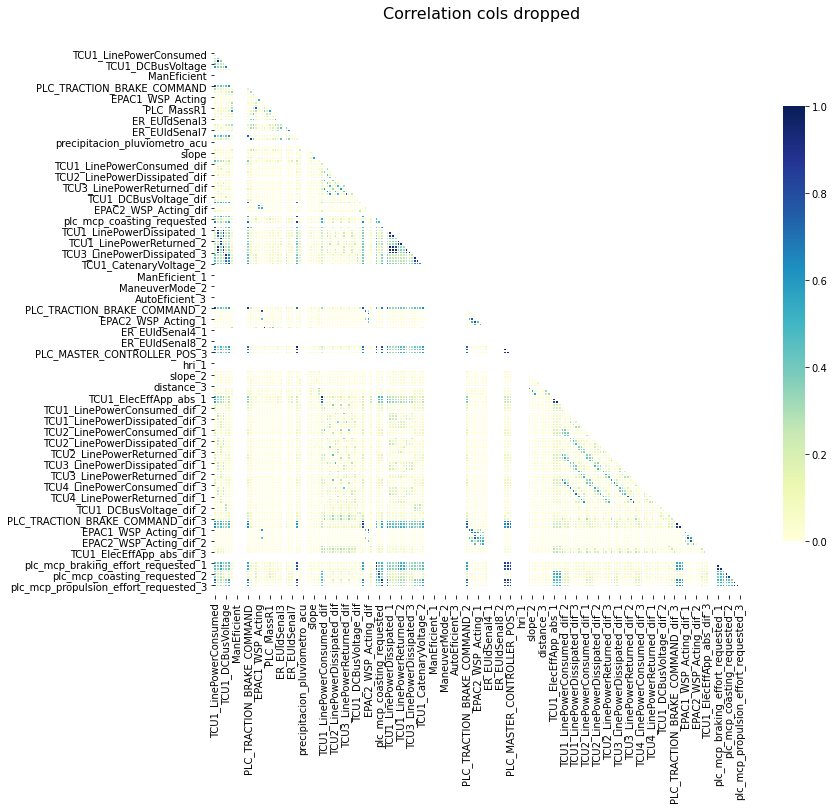

TCU2_LinePowerDissipated
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerDissipated
56 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Ax

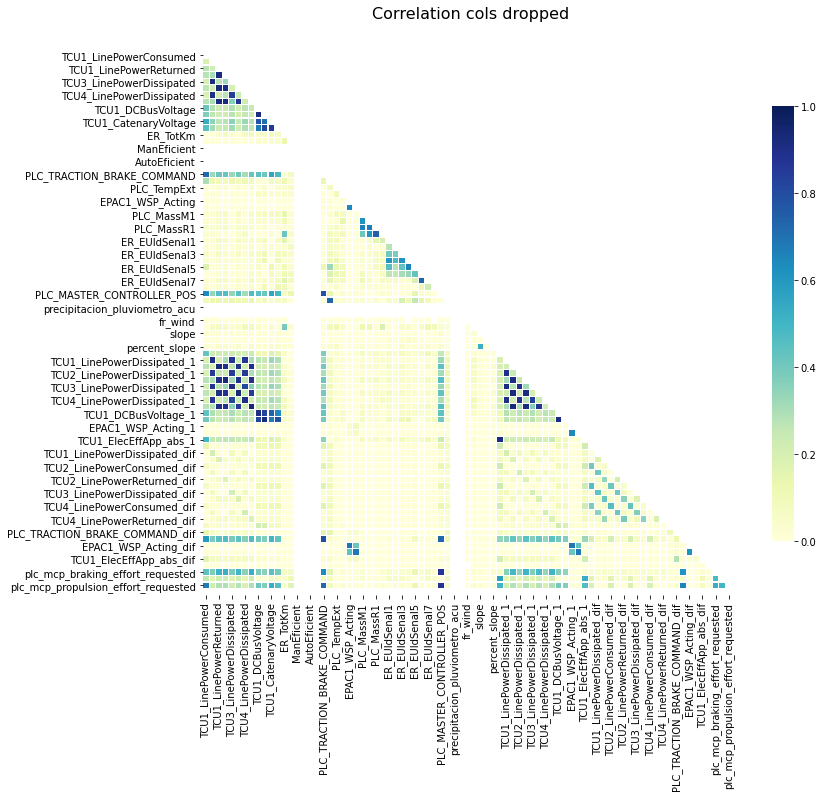

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Spe

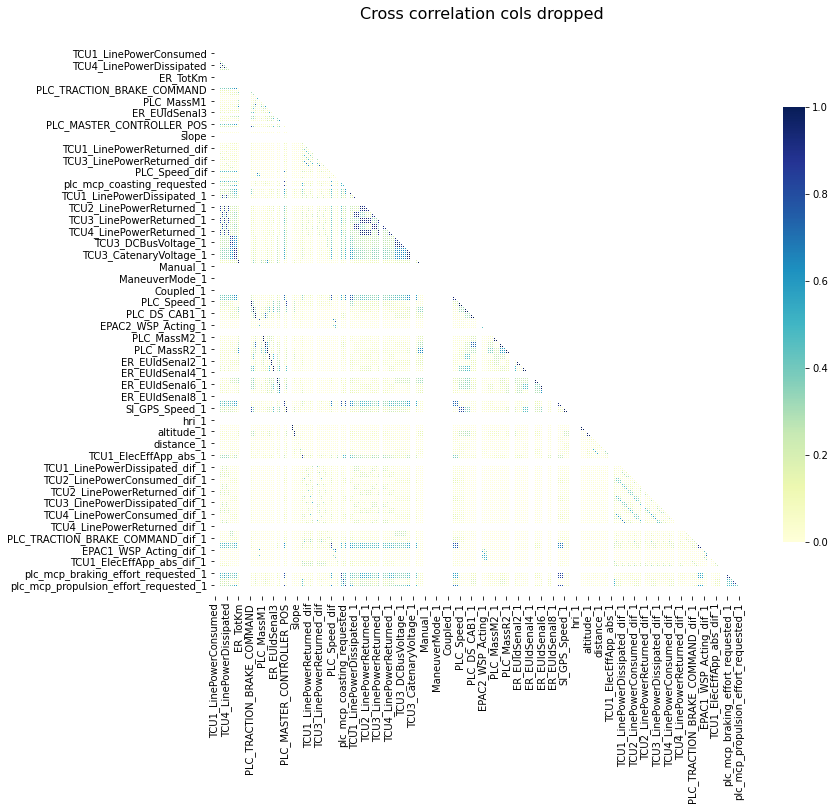

80 / 276
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltag

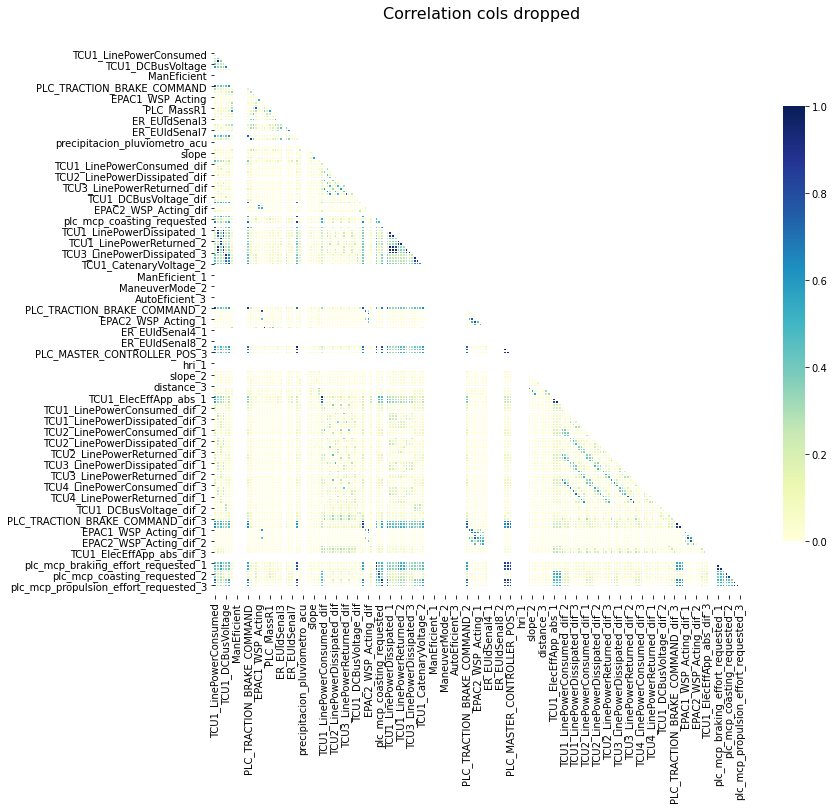

TCU2_LinePowerReturned
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerReturned
56 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Spe

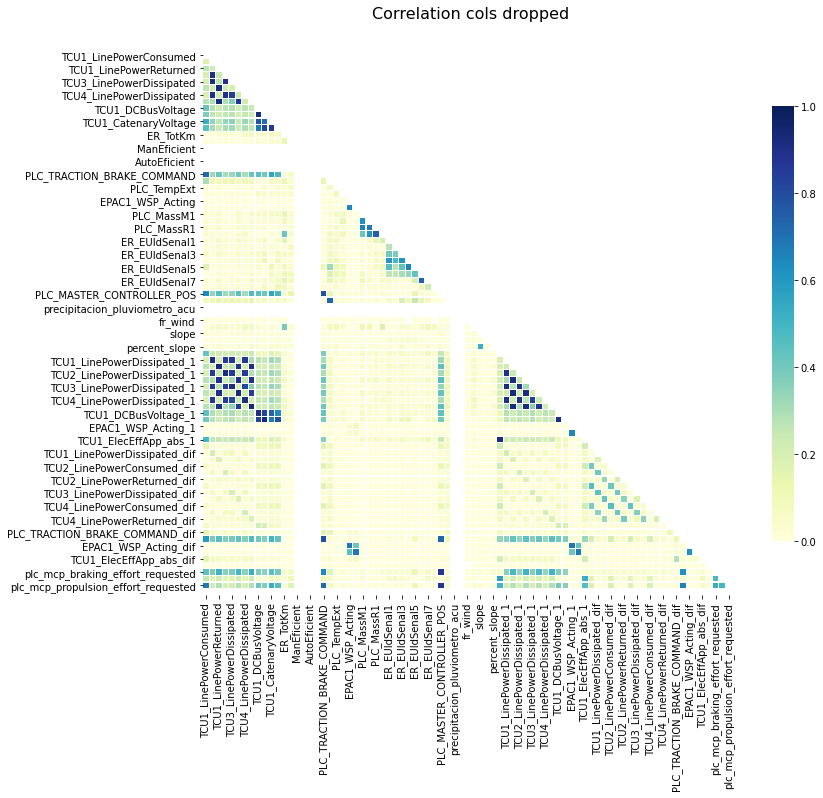

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed

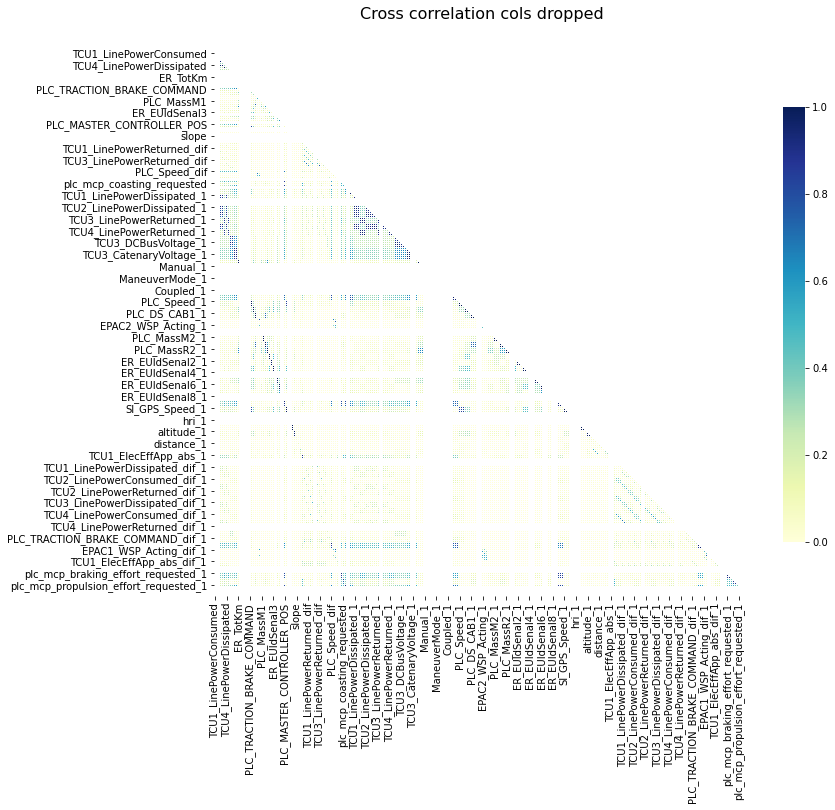

80 / 276
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU2_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_

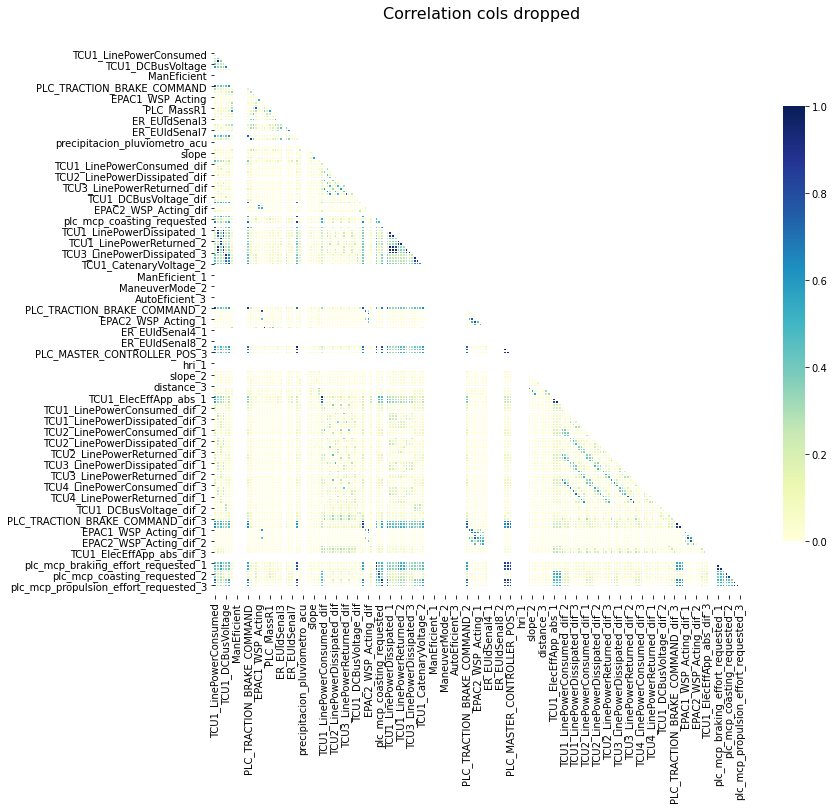

TCU3_LinePowerConsumed
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerConsumed
55 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_LinePowerConsumed
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_Axle1Speed_abs_1
TCU2_ElecEffApp_abs_dif
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
T

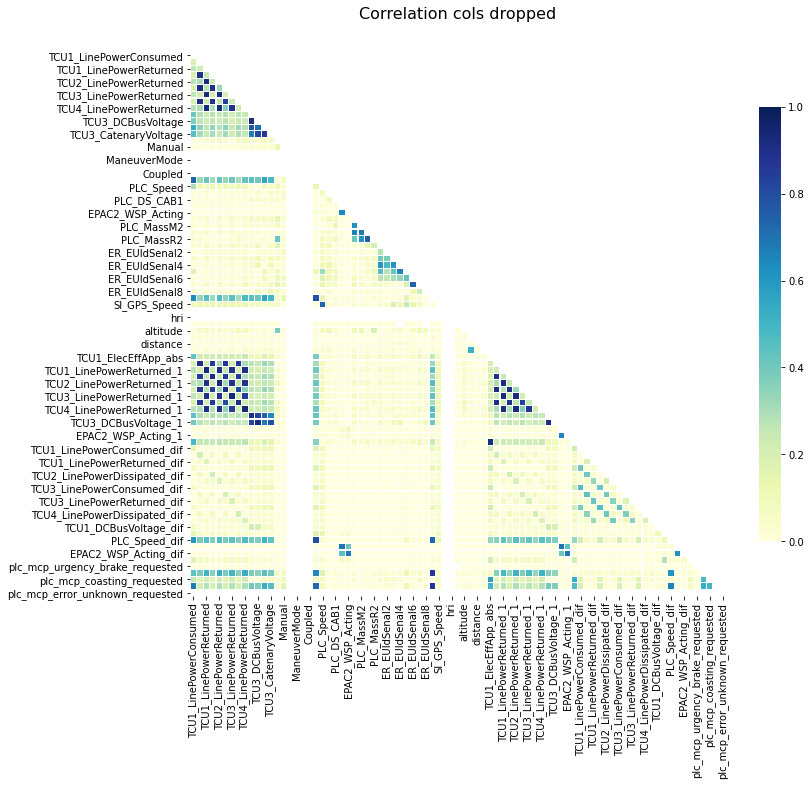

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_LinePowerConsumed
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_Axle1Speed_abs_1
TCU2_ElecEffApp_abs_dif
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed_abs_1
TCU3_LinePowerConsumed_

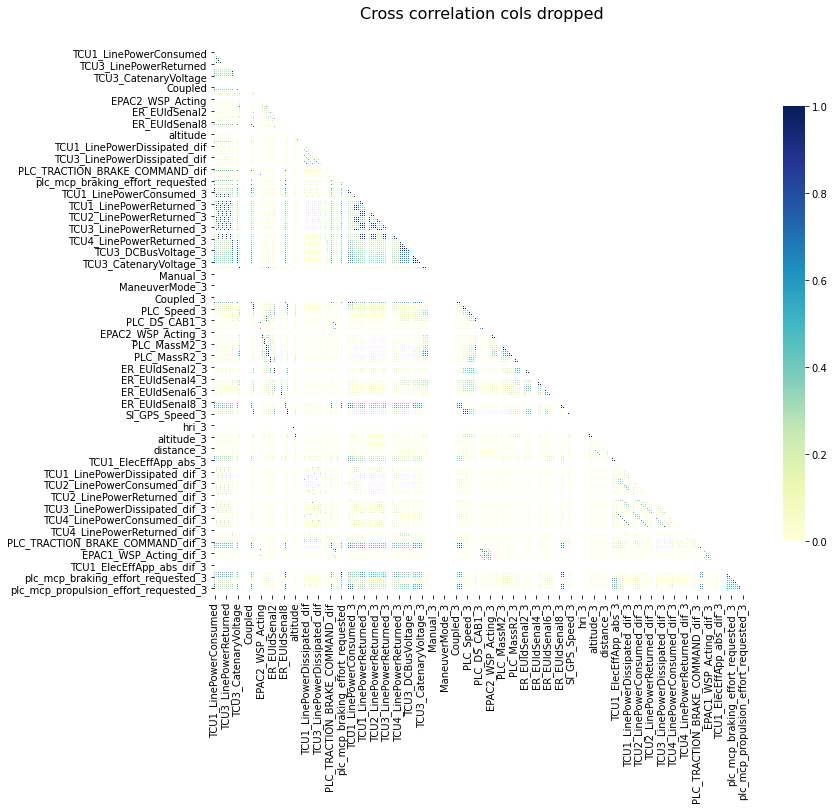

84 / 280
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_LinePowerConsumed
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_Axle1Speed_abs_1
TCU2_ElecEffApp_abs_dif
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed_abs_1
TCU3_L

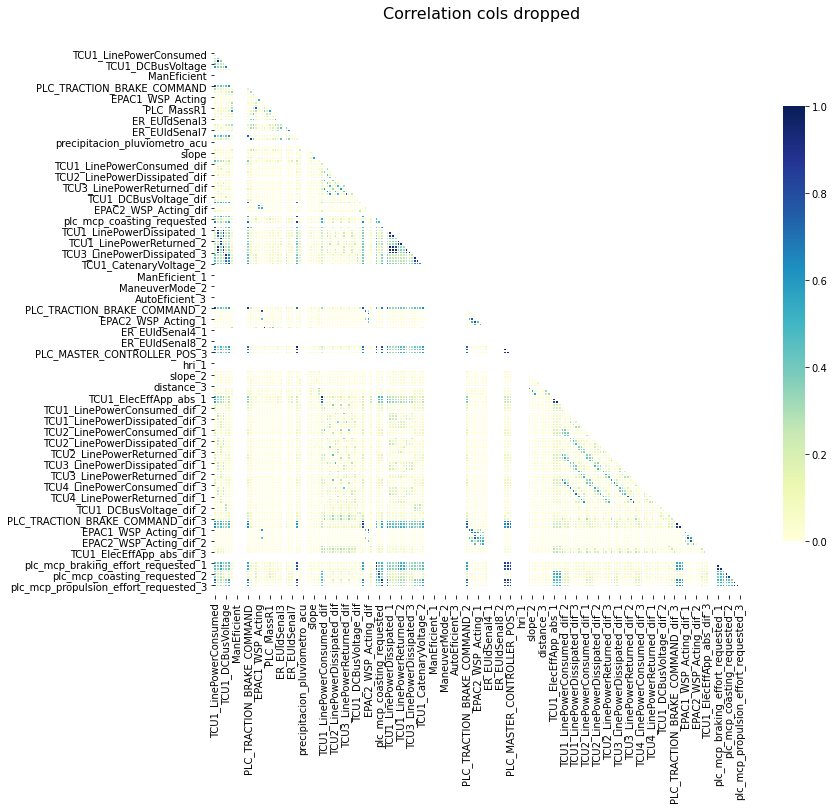

TCU3_LinePowerDissipated
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerDissipated
56 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Ax

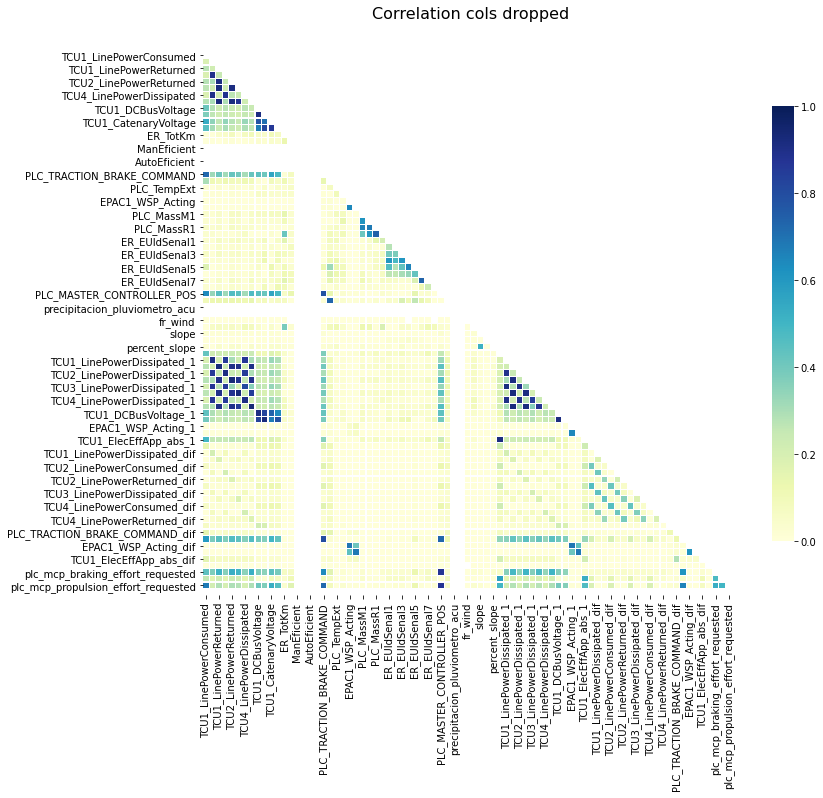

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Spe

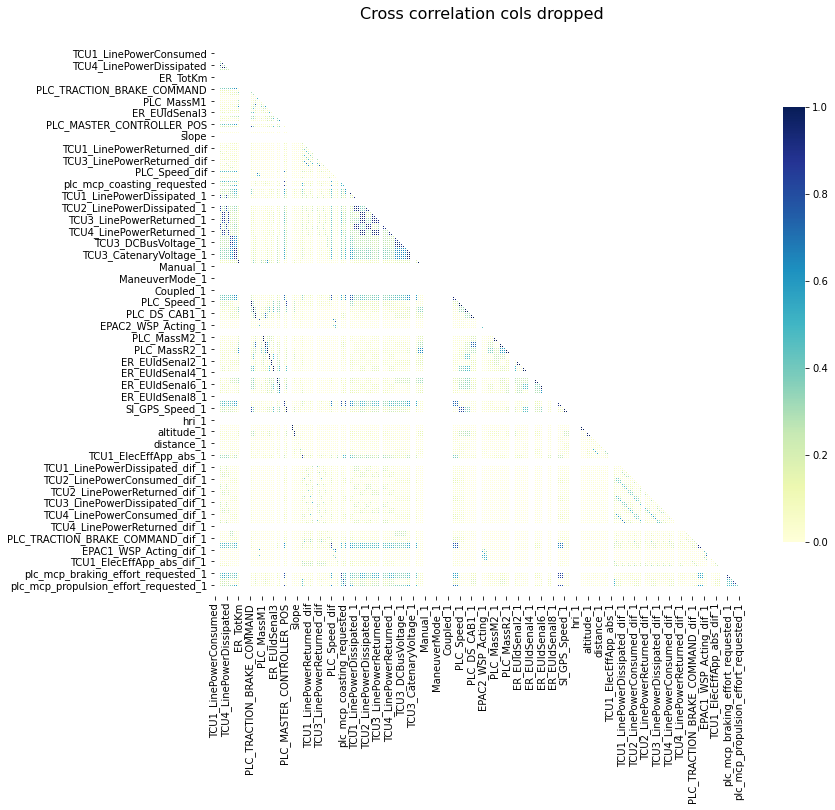

84 / 276
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltag

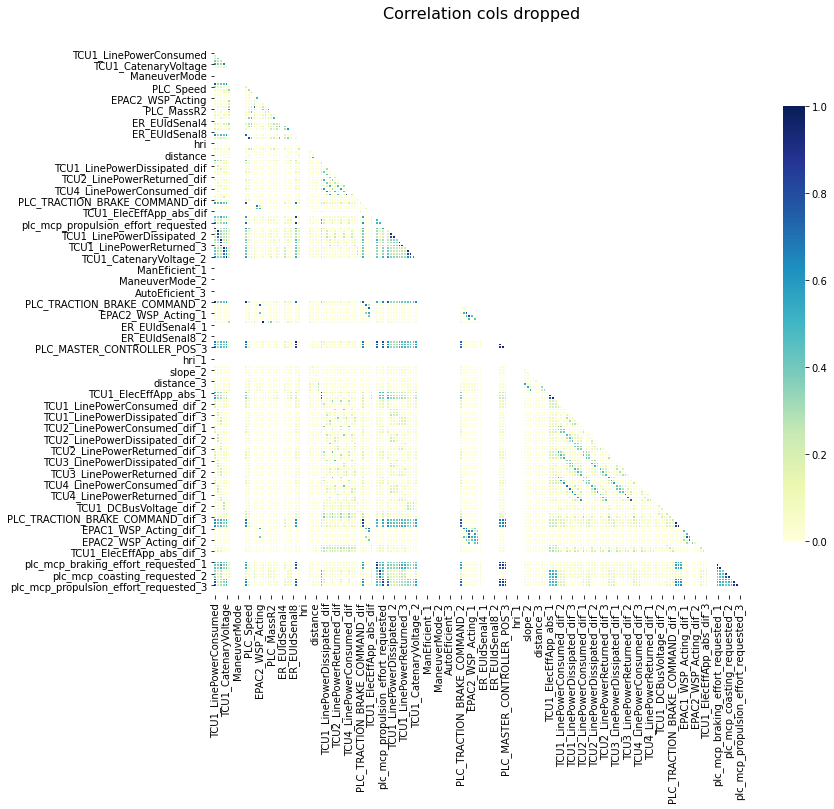

TCU3_LinePowerReturned
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerReturned
56 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Spe

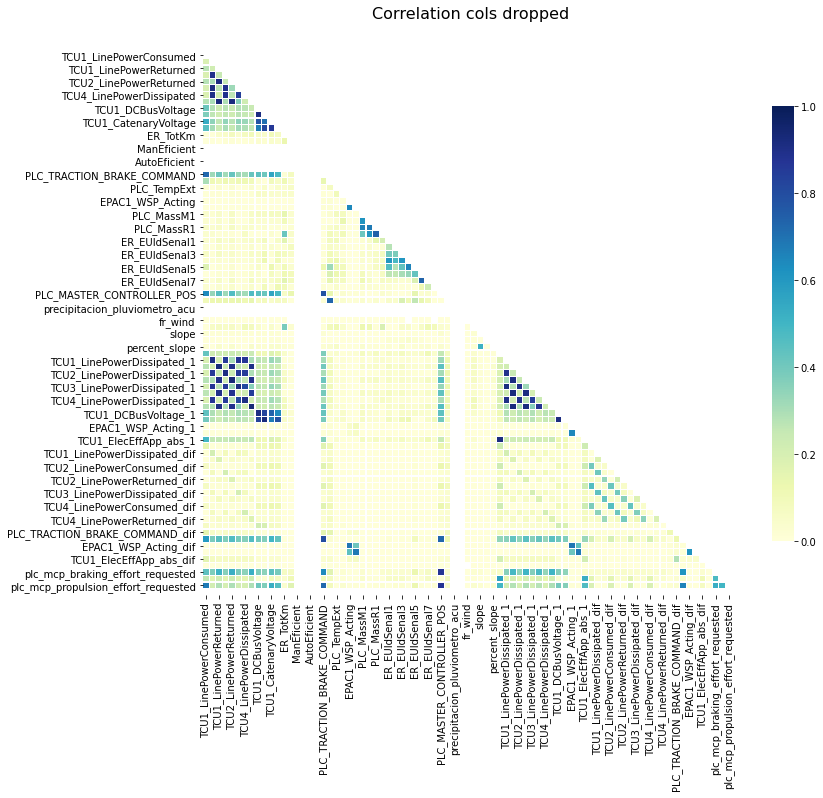

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed

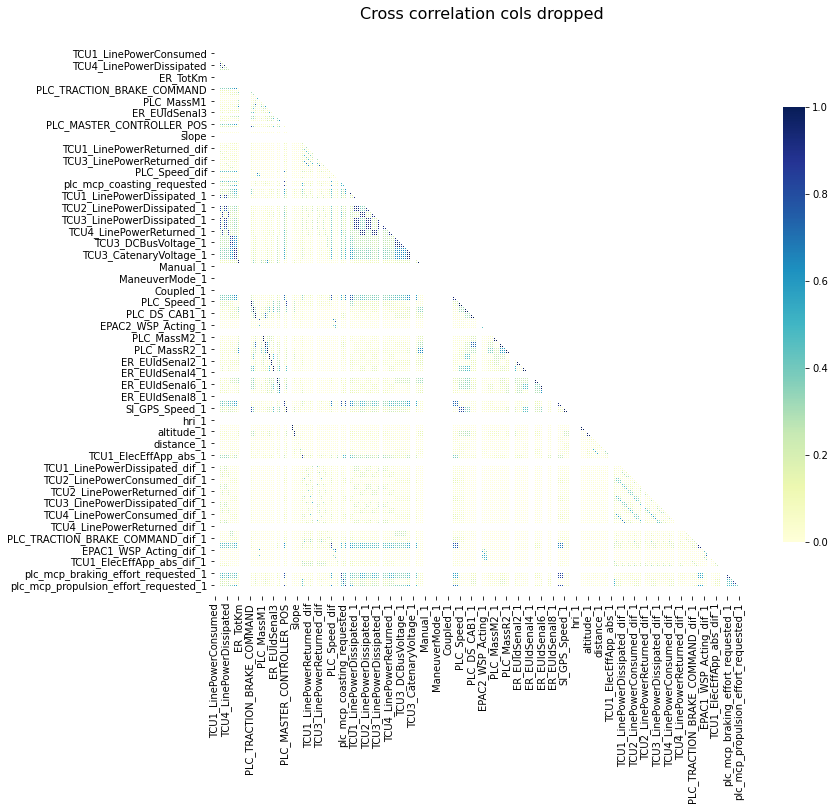

80 / 276
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU3_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_

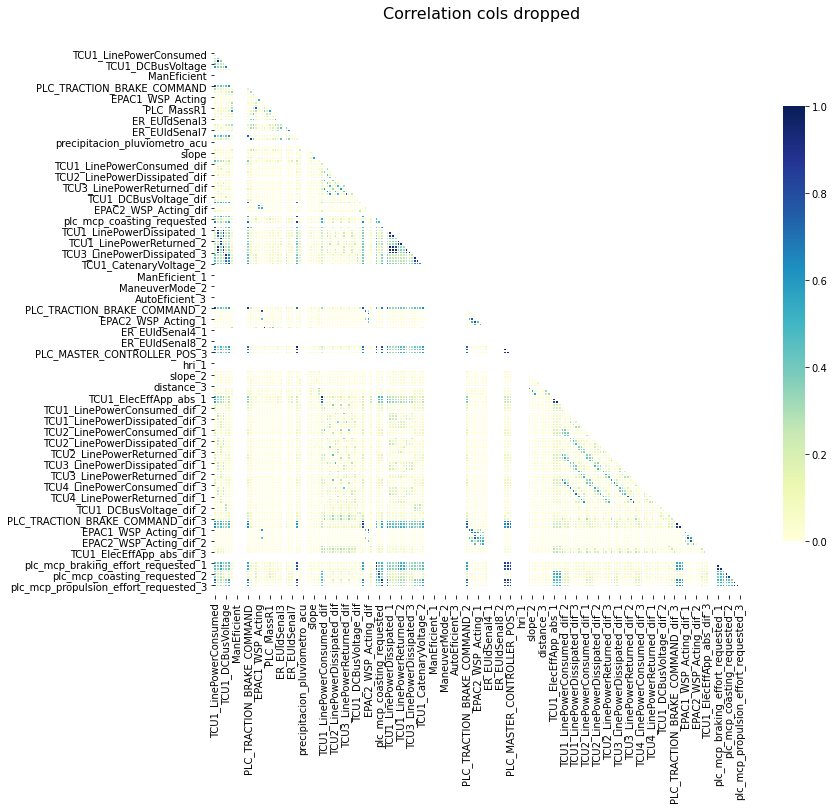

TCU4_LinePowerConsumed
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerConsumed
55 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_LinePowerConsumed
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif


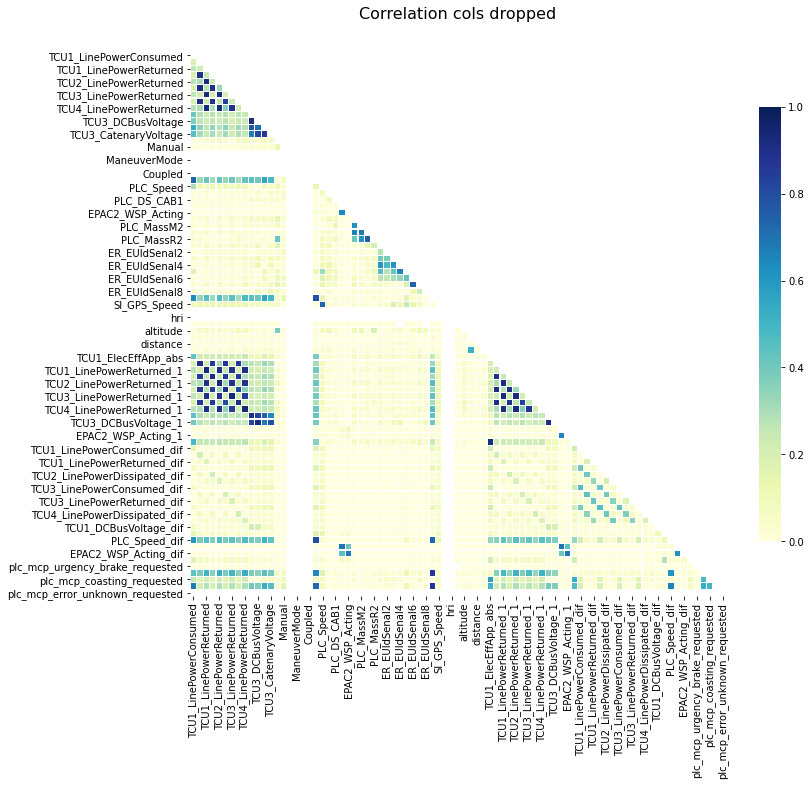

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_LinePowerConsumed
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed_abs_1


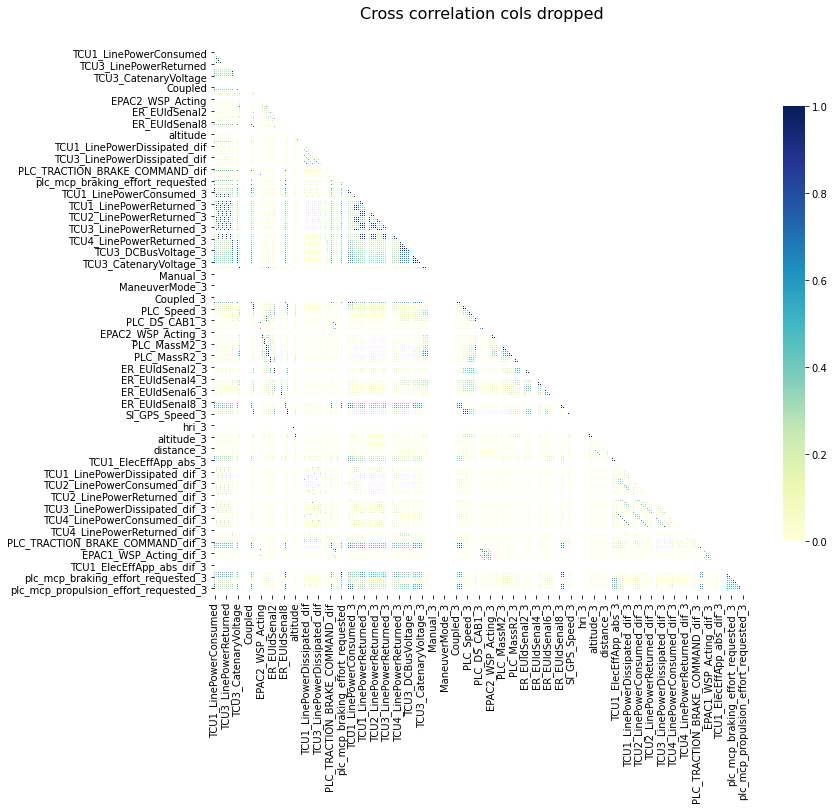

84 / 280
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerConsumed
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_LinePowerConsumed
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_

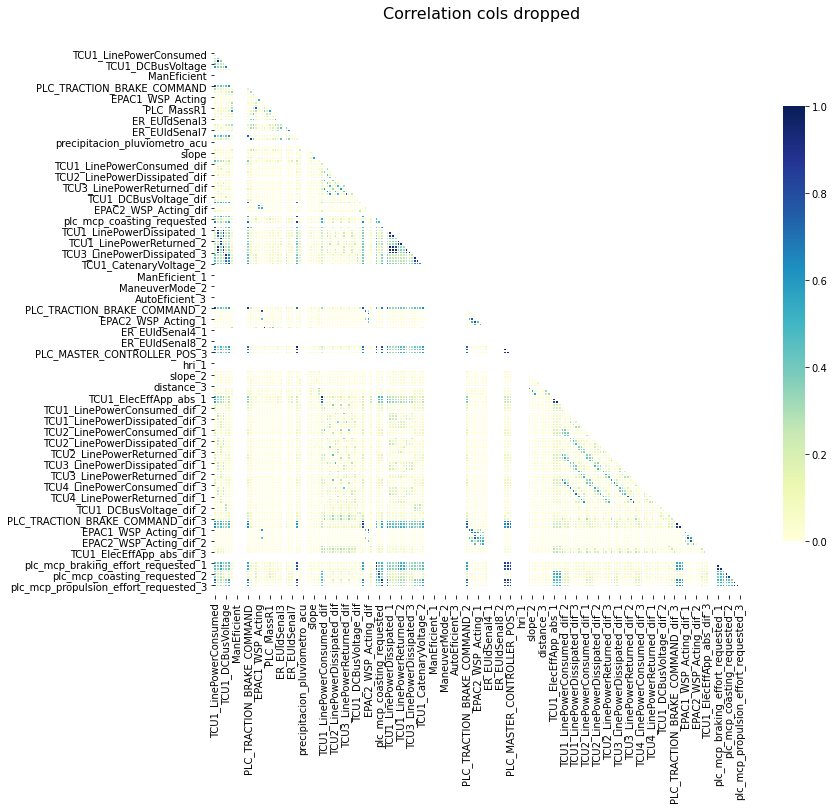

TCU4_LinePowerDissipated
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerDissipated
56 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Ax

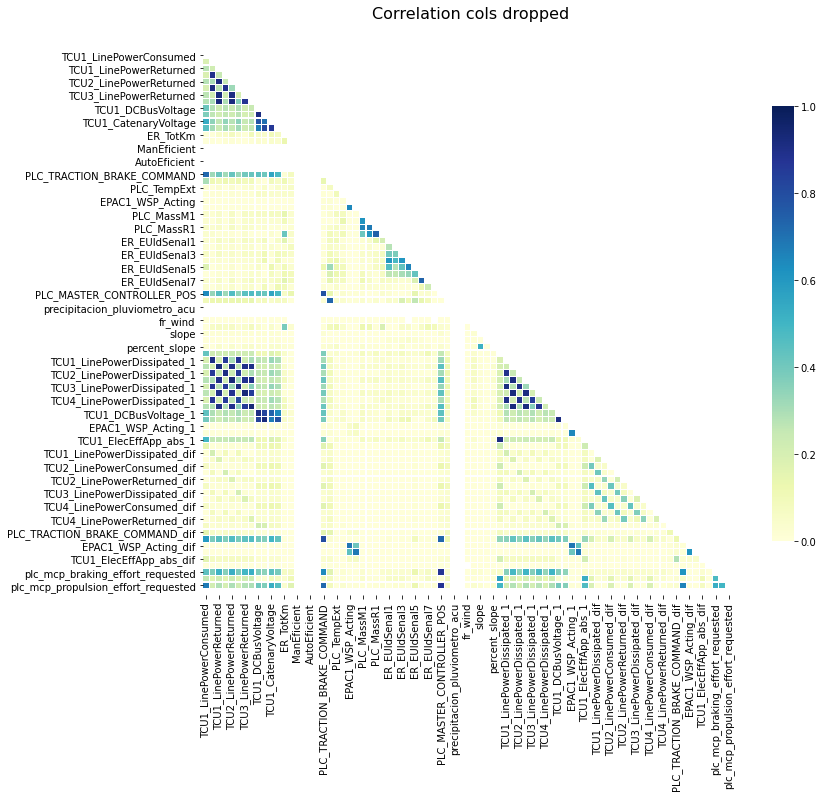

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Spe

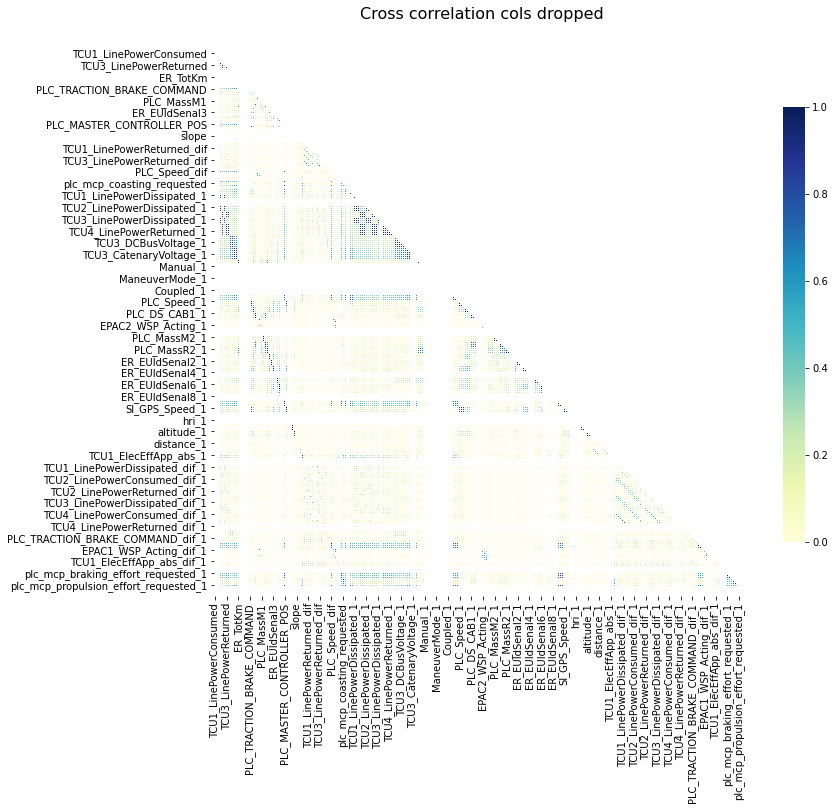

80 / 276
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerDissipated
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltag

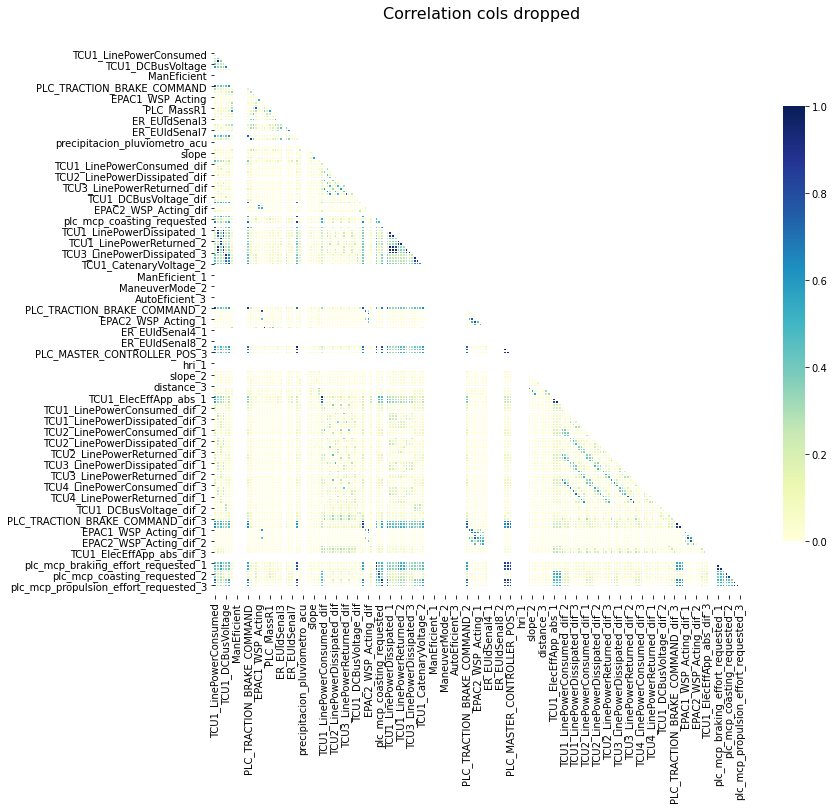

TCU4_LinePowerReturned
Analizamos la correlacion
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerReturned
56 / 138
Analizamos la correlacion, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Spe

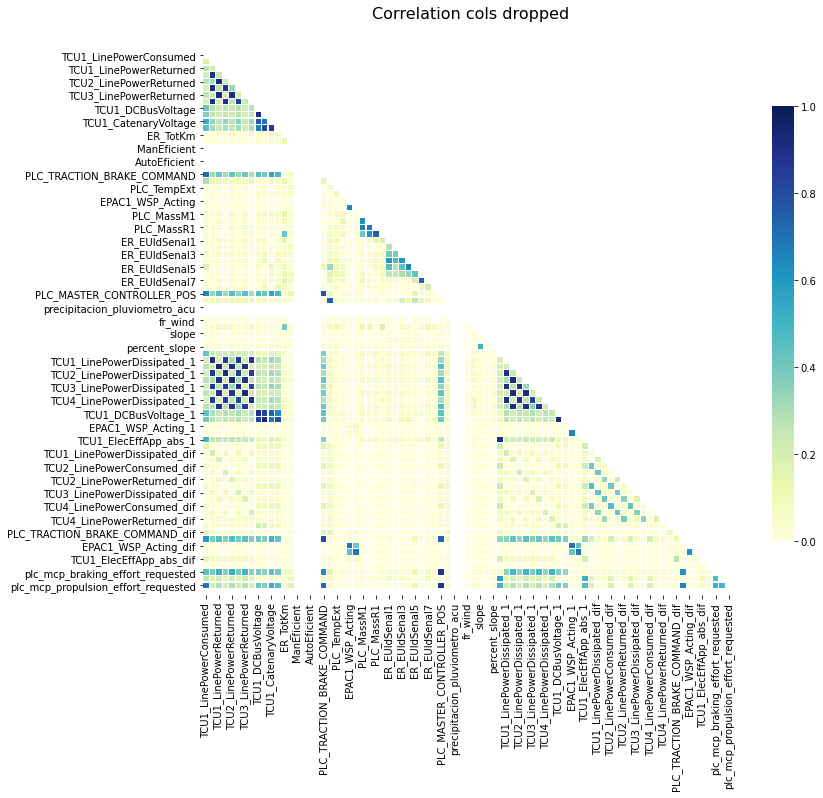

Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed

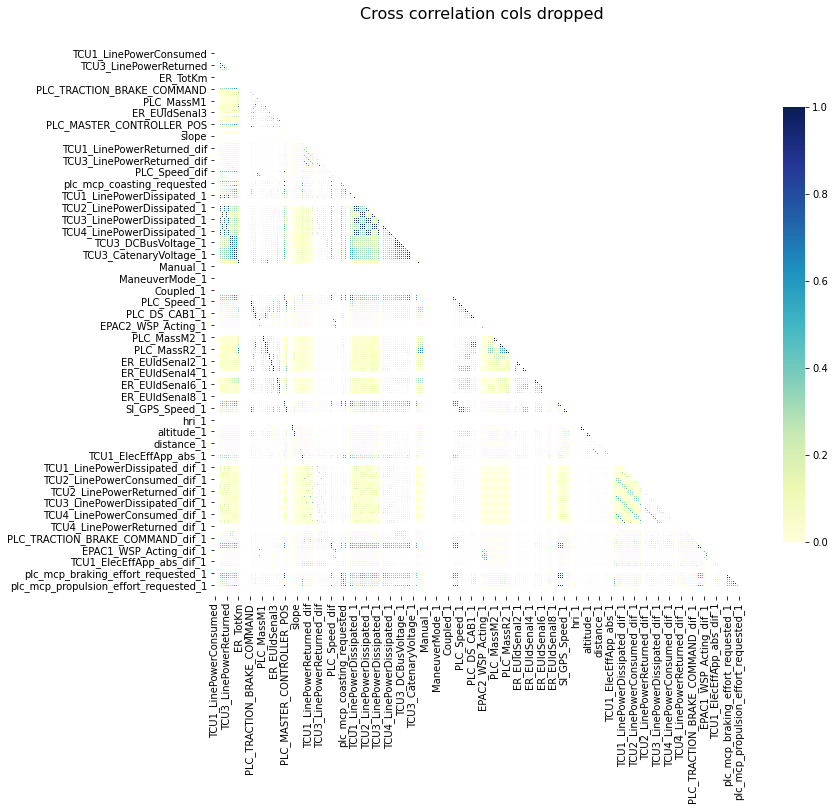

80 / 276
Analizamos la correlacion cruzada, eliminamos las variables descartadas en el analisis de correlacion cruzada
Ignoramos:
ut
ts_date
date_day
TCU4_LinePowerReturned
TCU2_DCBusVoltage_dif
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
TCU4_Axle1Speed_abs_1
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
TCU2_Axle2Speed_abs
TCU2_LinePowerConsumed
TCU3_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_

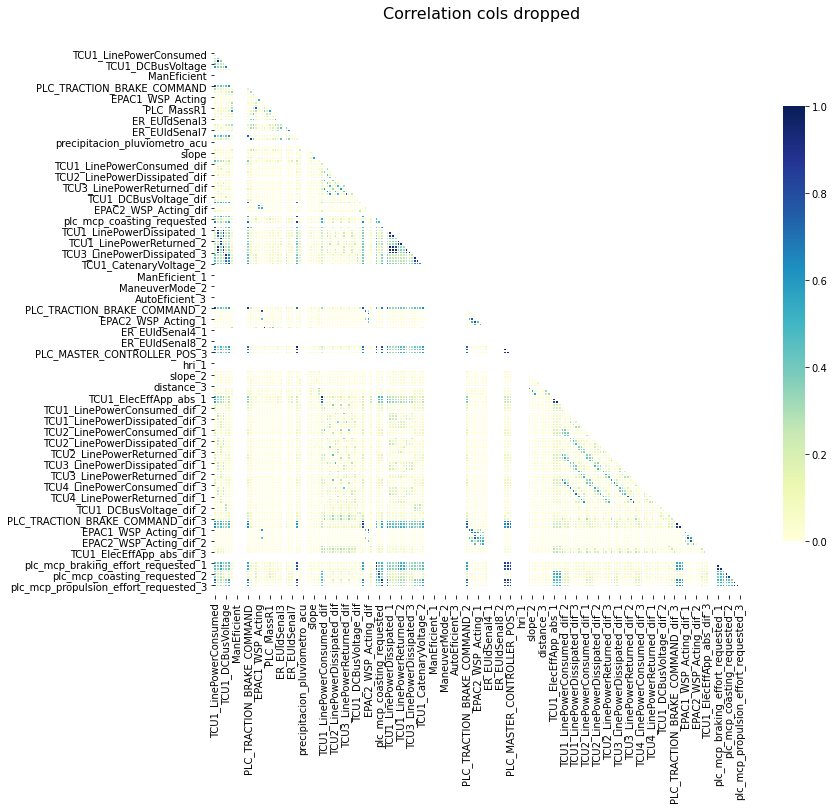

In [25]:
conf_dict['columns_2_drop']={}
visualize = True
for target in variables_objetivo:
    print (target)
    conf_dict['columns_2_drop'][target] = analysis_columns_to_drop(df.copy(),[target], visualize = SHOW_PLOT)


In [26]:
for target in variables_objetivo:
    print (target)

    print (len(conf_dict['columns_2_drop'][target]['corr_drops']), len(conf_dict['columns_2_drop'][target]['cross_corr_drops']))
    print ("\n".join(conf_dict['columns_2_drop'][target]['corr_drops']))
    print ()
    print ("\n".join(conf_dict['columns_2_drop'][target]['cross_corr_drops']))
    print ('\n\n\n\n')


TCU1_LinePowerConsumed
55 84
TCU2_DCBusVoltage_dif
TCU3_Axle2Speed_abs_1
TCU4_ElecEffApp_abs_1
TCU2_LinePowerConsumed_1
TCU4_CatenaryVoltage
TCU4_DCBusVoltage
TCU4_Axle2Speed_abs
TCU2_Axle1Speed_abs
TCU1_Axle2Speed_abs_dif
TCU4_ElecEffApp_abs_dif
PLC_TRACTION_BRAKE_COMMAND_1
TCU4_Axle1Speed_abs
TCU4_Axle1Speed_abs_dif
TCU4_Axle2Speed_abs_1
TCU1_Axle2Speed_abs
TCU1_Axle1Speed_abs_dif
lat_wind
PLC_VLinea_M2
TCU2_DCBusVoltage_1
TCU3_DCBusVoltage_dif
TCU2_Axle1Speed_abs_dif
TCU2_ElecEffApp_abs
PLC_DS_CAB2
TCU3_Axle1Speed_abs
TCU1_LinePowerConsumed_1
TCU1_Axle1Speed_abs_1
TCU4_DCBusVoltage_dif
TCU3_Axle2Speed_abs_dif
ImpSpeedMode
TCU3_Axle1Speed_abs_dif
TCU3_LinePowerConsumed
TCU3_Axle1Speed_abs_1
TCU3_Axle2Speed_abs
TCU2_ElecEffApp_abs_dif
TCU2_ElecEffApp_abs_1
TCU2_DCBusVoltage
TCU2_Axle1Speed_abs_1
TCU4_DCBusVoltage_1
TCU2_Axle2Speed_abs_1
TCU3_LinePowerConsumed_1
TCU3_ElecEffApp_abs_dif
TCU4_LinePowerConsumed_1
PLC_VLinea_M1
TCU2_CatenaryVoltage
TCU3_ElecEffApp_abs
TCU3_ElecEffApp_abs_1

# Save conf dict


In [27]:
#with open("/content/drive/MyDrive/CAFcoding/dataset/20201118_fullday_etl_conf.pickle","wb") as f:
with open("/content/drive/MyDrive/CAFcoding/dataset/conf_dict_drop.pickle","wb") as f:
    pickle.dump( conf_dict, f)



In [28]:
# import pickle
# with open("/content/drive/MyDrive/CAFcoding/dataset/20201118_fullday_etl_conf.pickle","rb") as f:
#   conf_dict=pickle.load( f)
